# "GAN Triplet Training"
- toc: true
- categories: ["Deep Learning"]


> This is an implementation of the paper: Zieba, Maciej, and Lei Wang. "Training triplet networks with gan." arXiv preprint arXiv:1704.02227 (2017).   


# Approach  

**Data:**  
I have used the MNIST dataset. It has 60,000 training and 10,000 testing samples. The labelled set has N (100 or 200) samples and the unlabelled set had all 60,000 samples.  
**Preprocessing:**  
No preprocessing, as mentioned in the paper.  
**Architecture:**  
I have followed the architecture used in Improved GAN (Salimans et al. 2016). The discriminator outputs M (16 or 32) features. The hyperparameters are same as in TripletGAN.  
**Loss:**  
For pretraining the GAN, I have followed the standard objective (Goodfellow, Ian, et al. 2014) 
For training the Improved GAN with Triplet loss, I have followed the Improved GAN objective (Salimans et al. 2016) with Triplet Loss in the Discriminator.  
**Training:**  
I initially pretrain the GAN with normal objective, for 50 epochs. Post that I train with the Improved GAN objective for 10 epochs.  
**Postprocessing:**  
No postprocessing, as mentioned in the paper.  
**Classifier:**  
I have used a 9-nearest neighbour classifier on top of M(16 or 32) features extracted by the discriminator.  
**Image Generation:**  
Created an array with noise and sent it to the generator to get the image. Have plotted them in the table below.


In [1]:
#hide
# Pretrained models. download them later if you want to compare the results
!wget -N --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ufF0r_fs64wjCHITE7GsGdAh7BKMNfTk' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ufF0r_fs64wjCHITE7GsGdAh7BKMNfTk" -O results.zip && rm -rf /tmp/cookies.txt > /tmp/xxy
!unzip -o results.zip
!pip install livelossplot > /tmp/xxy

Archive:  results.zip
  inflating: models/D_16_100.pkl     
  inflating: models/D_16_200.pkl     
  inflating: models/D_32_100.pkl     
  inflating: models/G_16_100.pkl     
  inflating: models/G_16_200.pkl     
  inflating: models/G_32_100.pkl     
  inflating: models/pretrain_D_16.pkl  
  inflating: models/pretrain_D_32.pkl  
  inflating: models/pretrain_G_16.pkl  
  inflating: models/pretrain_G_32.pkl  


# Imports

In [2]:
#collapse-hide
# Reference
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# https://github.com/andreasveit/triplet-network-pytorch
import math
import os
import sys
from pathlib import Path
from pprint import pprint

import numpy as np
from PIL import Image
from scipy.spatial.distance import cdist
# from torch import cdist
from sklearn import preprocessing
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm.auto import tqdm as tq

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt


# References

In [3]:
#collapse-hide
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py
# https://www.kaggle.com/hirotaka0122/triplet-loss-with-pytorch
# https://github.com/openai/improved-gan/blob/master/mnist_svhn_cifar10/train_mnist_feature_matching.py
# https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb
# https://github.com/eladhoffer/TripletNet
# https://stackoverflow.com/questions/26210471/scikit-learn-gridsearch-giving-valueerror-multiclass-format-is-not-supported

# Utils

In [4]:
#collapse-hide
class Arguments():
  def __init__(self):
    self.batch_size=100
    self.epochs=10
    self.lr=0.003
    self.momentum=0.5
    self.cuda=torch.cuda.is_available()
    self.seed=1
    self.log_interval=100
    self.save_interval=5
    self.unlabel_weight=1
    self.logdir='./logfile'
    self.savedir='./models'
    self.load_saved=True

args = Arguments()
np.random.seed(args.seed)
torch.manual_seed(args.seed)

results = {}
def log_sum_exp(x, axis = 1):
  m = torch.max(x, dim = 1)[0]
  return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = axis))

def reset_normal_param(L, stdv, weight_scale = 1.):
  assert type(L) == torch.nn.Linear
  torch.nn.init.normal(L.weight, std=weight_scale / math.sqrt(L.weight.size()[0]))

def show_gen_images(gan):
  num_images=4
  arr = gan.draw(num_images)
  square_dim = num_images//2
  f, axarr = plt.subplots(square_dim,square_dim)
  # f.set_figheight(10)
  # f.set_figwidth(10)
  for i in range(square_dim):
    for j in range(square_dim):
      axarr[i,j].imshow(arr[i*square_dim+j],cmap='gray')
      axarr[i,j].axis('off')

# https://github.com/Sleepychord/ImprovedGAN-pytorch/blob/master/functional.py#L13
class LinearWeightNorm(torch.nn.Module):
  def __init__(self, in_features, out_features, bias=True, weight_scale=None, weight_init_stdv=0.1):
    super(LinearWeightNorm, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.randn(out_features, in_features) * weight_init_stdv)
    if bias:
        self.bias = Parameter(torch.zeros(out_features))
    else:
        self.register_parameter('bias', None)
    if weight_scale is not None:
        assert type(weight_scale) == int
        self.weight_scale = Parameter(torch.ones(out_features, 1) * weight_scale)
    else:
        self.weight_scale = 1
  def forward(self, x):
    W = self.weight * self.weight_scale / torch.sqrt(torch.sum(self.weight ** 2, dim = 1, keepdim = True))
    return F.linear(x, W, self.bias)
  def __repr__(self):
    return self.__class__.__name__ + '(' \
        + 'in_features=' + str(self.in_features) \
        + ', out_features=' + str(self.out_features) \
        + ', weight_scale=' + str(self.weight_scale) + ')'

# Datasets

In [5]:
# Reference https://github.com/Sleepychord/ImprovedGAN-pytorch/blob/master/Datasets.py
def MNISTLabel(class_num):
  raw_dataset = datasets.MNIST('../data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                  ]))
  class_tot = [0] * 10
  data = []
  labels = []
  tot = 0
  perm = np.random.permutation(raw_dataset.__len__())
  for i in range(raw_dataset.__len__()):
    datum, label = raw_dataset.__getitem__(perm[i])
    if class_tot[label] < class_num:
      data.append(datum.numpy())
      labels.append(label)
      class_tot[label] += 1
      tot += 1
      if tot >= 10 * class_num:
          break
  
  times = int(np.ceil(60_000 / len(data)))
  return TensorDataset(torch.FloatTensor(np.array(data)).repeat(times,1,1,1), torch.LongTensor(np.array(labels)).repeat(times))

def MNISTUnlabel():
  raw_dataset = datasets.MNIST('../data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                  ]))
  return raw_dataset
def MNISTTest():
    return datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
# Reference https://github.com/adambielski/siamese-triplet/blob/master/datasets.py#L79
class MNISTTriplet(Dataset):
  def __init__(self, mnist_dataset):
    self.mnist_dataset = mnist_dataset.tensors
    self.train_labels = self.mnist_dataset[1]
    self.train_data = self.mnist_dataset[0]
    self.labels_set = set(self.train_labels.numpy())
    self.label_to_indices = {}
    for label in self.labels_set:
      self.label_to_indices[label] = np.where(self.train_labels.numpy() == label)[0]

  def __getitem__(self, index):
    img1, label1 = self.train_data[index], self.train_labels[index].item()
    positive_index = index
    while positive_index == index:
      positive_index = np.random.choice(self.label_to_indices[label1])
    negative_label = np.random.choice(list(self.labels_set - set([label1])))
    negative_index = np.random.choice(self.label_to_indices[negative_label])
    img3 = self.train_data[negative_index]
    img2 = self.train_data[positive_index]
    return img1, img2, img3

  def __len__(self):
    return len(self.mnist_dataset[1])
# Reference https://github.com/adambielski/siamese-triplet/blob/master/losses.py
class TripletLoss(nn.Module):
  def __init__(self):
    super(TripletLoss, self).__init__()

  def forward(self, anchor, positive, negative, size_average=True):
    d_positive = torch.sqrt(torch.sum((anchor - positive).pow(2),axis=1))
    d_negative = torch.sqrt(torch.sum((anchor - negative).pow(2),axis=1))
    z = torch.cat((d_positive.unsqueeze(1),d_negative.unsqueeze(1)),axis=1)
    z = log_sum_exp(z)
    return -torch.mean(d_negative) + torch.mean(z)

MNISTUnlabel()
MNISTTest()

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

# GAN

## Architecture: Generator and Discriminator

In [6]:
# https://github.com/Sleepychord/ImprovedGAN-pytorch/blob/master/Nets.py
class Discriminator(nn.Module):
  def __init__(self, input_dim = 28 ** 2, output_dim = 10):
    super(Discriminator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.layers = torch.nn.ModuleList([
      LinearWeightNorm(input_dim, 1000),
      LinearWeightNorm(1000, 500),
      LinearWeightNorm(500, 250),
      LinearWeightNorm(250, 250),
      LinearWeightNorm(250, 250)]
    )
    self.final = LinearWeightNorm(250, output_dim, weight_scale=1)
    self.reduce = nn.Sequential(
      nn.Linear(self.output_dim, 1),
      nn.Sigmoid(),
    )

  def forward(self, x, feature = False, pretrain=False):
    x = x.view(-1, self.input_dim)
    noise = torch.randn(x.size()) * 0.3 if self.training else torch.Tensor([0])
    if args.cuda:
      noise = noise.cuda()
    x = x + noise
    for i in range(len(self.layers)):
      m = self.layers[i]
      x_f = F.relu(m(x))
      noise = torch.randn(x_f.size()) * 0.5 if self.training else torch.Tensor([0])
      if args.cuda:
        noise = noise.cuda()
      x = (x_f + noise)
    if feature:
      return x_f
    out = self.final(x)
    if pretrain:
      out = self.reduce(out)
    return out


class Generator(nn.Module):
  def __init__(self, z_dim, output_dim = 28 * 28):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.fc1 = nn.Linear(z_dim, 500, bias = False)
    self.bn1 = nn.BatchNorm1d(500, affine = False, eps=1e-6, momentum = 0.5)
    self.fc2 = nn.Linear(500, 500, bias = False)
    self.bn2 = nn.BatchNorm1d(500, affine = False, eps=1e-6, momentum = 0.5)
    self.fc3 = LinearWeightNorm(500, output_dim, weight_scale = 1)
    self.bn1_b = Parameter(torch.zeros(500))
    self.bn2_b = Parameter(torch.zeros(500))
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self, batch_size, draw=None):
    if draw is None:
      x = torch.rand(batch_size, self.z_dim)
    else:
      x = draw
    if args.cuda:
      x = x.cuda()
    x = F.softplus(self.bn1(self.fc1(x)) + self.bn1_b)
    x = F.softplus(self.bn2(self.fc2(x)) + self.bn2_b)
    x = F.softplus(self.fc3(x))
    return x

# Pretraining

## GAN Class

In [7]:
# Reference: https://github.com/Sleepychord/ImprovedGAN-pytorch/blob/master/ImprovedGAN.py
class ImprovedGAN(object):
  def __init__(self, G, D, labeled, unlabeled, test):
    self.G = G
    self.D = D
    # if(args.mode == 'train'):
    g_name = 'G_'+str(D.output_dim)+'_'+str(args.labeled)+'.pkl'
    d_name = 'D_'+str(D.output_dim)+'_'+str(args.labeled)+'.pkl'
    # else:
    g_name_pretrain = 'pretrain' + '_G_'+str(D.output_dim)+'.pkl'
    d_name_pretrain = 'pretrain' + '_D_'+str(D.output_dim)+'.pkl'

    if args.mode == 'pretrain':
      self.g_path = Path(args.savedir) / g_name_pretrain
      self.d_path = Path(args.savedir) / d_name_pretrain
    else:
      self.g_path = Path(args.savedir) / g_name
      self.d_path = Path(args.savedir) / d_name

    if os.path.exists(args.savedir) and args.load_saved:
      print('Loading model ' + args.savedir)
      if False and os.path.exists(self.g_path):
        self.G.load_state_dict(torch.load(self.g_path))
        self.D.load_state_dict(torch.load(self.d_path))
      else:
        print('Loaded pretrain')
        self.G.load_state_dict(torch.load(Path(args.savedir) / g_name_pretrain))
        self.D.load_state_dict(torch.load(Path(args.savedir) / d_name_pretrain))
    else:
      print('Creating model')
      if not os.path.exists(args.savedir):
        os.makedirs(args.savedir)
      torch.save(self.G.state_dict(), self.g_path)
      torch.save(self.D.state_dict(), self.d_path)
    # self.writer = tensorboardX.SummaryWriter(log_dir=args.logdir)
    if args.cuda:
      self.G.cuda()
      self.D.cuda()
    
    self.Doptim = optim.Adam(self.D.parameters(), lr=args.lr, betas= (args.momentum, 0.999))
    self.Goptim = optim.Adam(self.G.parameters(), lr=args.lr, betas = (args.momentum,0.999))
    self.knn = KNeighborsClassifier(n_neighbors=9)
    self.tripletloss = TripletLoss()
    self.drawnoise = torch.rand(4, self.G.z_dim)
    self.labeled = labeled
    self.unlabeled = unlabeled
    self.test = test

  def get_features(self,dataset):
    loader = DataLoader(dataset, batch_size = args.batch_size, shuffle=True, drop_last=True, num_workers = 4)
    X = []
    y = []
    for (data,label) in loader:
      data = data.cuda()
      X += self.D(data)
      y += label
      # del data
    del loader,data
    X = torch.stack(X).data.cpu().numpy()
    y = torch.LongTensor(y).data.cpu().numpy()
    # X = torch.stack(X)
    # y = torch.LongTensor(y)
    return X,y

  def trainknn(self):
    X,y = self.get_features(self.unlabeled)
    self.knn.fit(X,y)
    print("Fit done")
    del X,y
  
  def calc_mAP(self,test_features, testy, train_features, trainy):
    Y = cdist(test_features,train_features)
    ind = np.argsort(Y,axis=1)
    print("Done argsort")
    del Y,train_features
    prec = 0.0
    num_classes = 10
    acc = [0.0] * num_classes
    test_len = len(test_features)
    # print("testlen",test_len)
    for k in range(test_len):
      class_values = trainy[ind[k,:]]
      y_true = (testy[k] == class_values)
      # print("ylen",y_true.shape[0])
      y_scores = np.arange(y_true.shape[0],0,-1)
      prec += average_precision_score(y_true, y_scores)

      for n in range(num_classes):
        a = class_values[0:(n+1)]
        counts = np.bincount(a)
        b = np.where(counts==np.max(counts))[0]
        if testy[k] in b:
          acc[n] = acc[n] + (1.0/float(len(b)))
    prec = prec/float(test_len)
    acc= [x / float(test_len) for x in acc]
    del ind,class_values,y_true,y_scores
    return np.mean(acc)*100,prec

  def evalknn(self,results):
    test_features, testy = self.get_features(self.test)
    train_features, trainy = self.get_features(self.unlabeled)
    accuracy,mAP = self.calc_mAP(test_features, testy, train_features, trainy)
    del test_features,testy,train_features,trainy
    results[args.mode+'_'+str(args.features)+'_'+str(args.labeled)] = [accuracy,mAP]
    return accuracy,mAP
  
  def draw(self, batch_size):
    self.G.eval()
    return self.G(batch_size,draw=self.drawnoise).view((batch_size,28,28)).data.cpu().numpy()

## Pretrain GAN

### Original GAN objective

In [8]:
def pretrain(self):
  # Reference: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py
  plotlosses = PlotLosses(groups={'loss': ['generator', 'discriminator']})
  # Tensor = torch.cuda.FloatTensor if args.cuda else torch.FloatTensor
  bce_loss = torch.nn.BCELoss()
  if args.cuda:
    bce_loss.cuda()

  dataloader = DataLoader(self.unlabeled, batch_size = args.batch_size, shuffle=True, drop_last=True, num_workers = 4)
  for epoch in tq(range(args.epochs)):
    losses = {'discriminator':0,'generator':0}
    for i, (imgs, _) in enumerate(dataloader):
      valid = torch.ones((imgs.size(0), 1))
      fake = torch.zeros((imgs.size(0), 1))

      train_imgs = imgs

      generated_images = self.G(args.batch_size)
      
      if args.cuda:
        valid, fake, train_imgs, generated_images = valid.cuda(), fake.cuda(), train_imgs.cuda(), generated_images.cuda()

      generator_loss = bce_loss(self.D(generated_images,pretrain=True), valid)
      
      self.Goptim.zero_grad()
      generator_loss.backward()
      self.Goptim.step()

      real_loss = bce_loss(self.D(train_imgs,pretrain=True), valid)
      fake_loss = bce_loss(self.D(generated_images.detach(),pretrain=True), fake)
      
      discriminator_loss = (fake_loss + real_loss) / 2

      self.Doptim.zero_grad()
      discriminator_loss.backward()
      self.Doptim.step()

      losses['generator'] += generator_loss.item()
      losses['discriminator'] += discriminator_loss.item()
    
    num_batches = len(self.unlabeled) / args.batch_size
    for key in losses:
      losses[key] /= num_batches
    
    plotlosses.update(losses)
    plotlosses.send()
    
    if (epoch + 1) % args.save_interval == 0:
      torch.save(self.G.state_dict(), self.g_path)
      torch.save(self.D.state_dict(), self.d_path)

ImprovedGAN.pretrain = pretrainargs.load_saved=False
args.epochs=50
args.mode = 'pretrain'

# m=16 n=100
args.labeled=100
args.features=16
gan = ImprovedGAN(Generator(z_dim=100), Discriminator(output_dim=args.features), MNISTLabel(args.labeled/10), MNISTUnlabel(), MNISTTest())
gan.pretrain()
# gan.trainknn()
print(gan.evalknn(results))
show_gen_images(gan)

### m=16

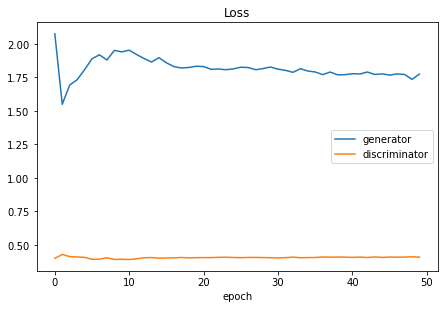

Loss
	generator        	 (min:    1.549, max:    2.075, cur:    1.775)
	discriminator    	 (min:    0.391, max:    0.429, cur:    0.409)

Done w cdist
(30.023548015873082, 0.15303857492111891)


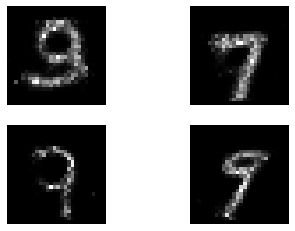

In [9]:
args.load_saved=True
args.epochs=50
args.mode = 'pretrain'

# m=16 n=100
args.labeled=100
args.features=16
gan = ImprovedGAN(Generator(z_dim=100), Discriminator(output_dim=args.features), MNISTLabel(args.labeled/10), MNISTUnlabel(), MNISTTest())
gan.pretrain()
# gan.trainknn()
print(gan.evalknn(results))
show_gen_images(gan)

### m=32

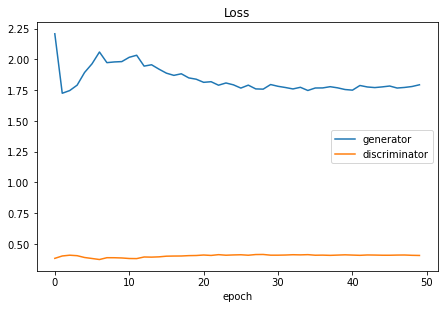

Loss
	generator        	 (min:    1.724, max:    2.207, cur:    1.793)
	discriminator    	 (min:    0.373, max:    0.414, cur:    0.406)

Done w cdist
(44.4227202380953, 0.1734273342974863)


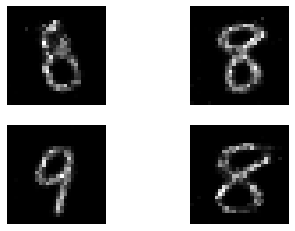

In [10]:
# m=32 n=100
args.features=32
gan = ImprovedGAN(Generator(z_dim=100), Discriminator(output_dim=args.features), MNISTLabel(args.labeled/10), MNISTUnlabel(), MNISTTest())
gan.pretrain()
# gan.trainknn()
print(gan.evalknn(results))
show_gen_images(gan)

# Main Training

### Improved GAN Objective + Triplet loss

In [11]:
# Reference: https://github.com/Sleepychord/ImprovedGAN-pytorch/blob/master/ImprovedGAN.py
def train_Discriminator(self, x1, x2, x3, x_unlabel):
  output_unlabel, output_fake = self.D(x_unlabel), self.D(self.G(x_unlabel.size()[0]).view(x_unlabel.size()).detach()) 
  loss_supervised = self.tripletloss(self.D(x1), self.D(x2), self.D(x3))
  logz_unlabel, logz_fake = log_sum_exp(output_unlabel), log_sum_exp(output_fake)
  loss_unsupervised = 0.5 * torch.mean(F.softplus(logz_fake)) + 0.5 * -torch.mean(logz_unlabel) + 0.5 * torch.mean(F.softplus(logz_unlabel))
  loss = args.unlabel_weight * loss_unsupervised + loss_supervised
  self.Doptim.zero_grad()
  loss.backward()
  self.Doptim.step()
  return loss_supervised.item(), loss_unsupervised.item()
    
def train_Generator(self, x_unlabel):
  fake = self.G(args.batch_size).view(x_unlabel.size())
  mom_gen = self.D(fake, feature=True).mean(dim=0)
  mom_unlabel = self.D(x_unlabel, feature=True).mean(dim=0)
  loss_feature_matching = torch.mean((mom_gen - mom_unlabel).pow(2))
  self.Goptim.zero_grad()
  self.Doptim.zero_grad()
  loss_feature_matching.backward()
  self.Goptim.step()
  return loss_feature_matching.item()
    
def train(self):
  plotlosses = PlotLosses(groups={'loss': ['supervised', 'unsupervised','generator']})
  for epoch in tq(range(args.epochs)):
    self.G.train()
    self.D.train()
    unlabel_loader1 = DataLoader(self.unlabeled, batch_size = args.batch_size, shuffle=True, drop_last=True, num_workers = 4)
    unlabel_loader2 = DataLoader(self.unlabeled, batch_size = args.batch_size, shuffle=True, drop_last=True, num_workers = 4).__iter__()
    label_loader = DataLoader(self.labeled, batch_size = args.batch_size, shuffle=True, drop_last=True, num_workers = 4).__iter__()
    
    # loss_supervised = loss_unsupervised = loss_generator = 0.
    losses = {'supervised':0,'unsupervised':0,'generator':0}
    for (unlabel1, _) in unlabel_loader1:
      unlabel2, _ = unlabel_loader2.next()
      x1,x2,x3 = label_loader.next()
      if args.cuda:
        x1, x2, x3, unlabel1, unlabel2 = x1.cuda(), x2.cuda(), x3.cuda(), unlabel1.cuda(), unlabel2.cuda()
      
      l_supervised, l_unsupervised = self.train_Discriminator(x1, x2, x3, unlabel1)
      
      losses['unsupervised'] += l_unsupervised
      losses['supervised'] += l_supervised
      
      generator_loss = self.train_Generator(unlabel2)
      if epoch > 1 and generator_loss > 1:
        generator_loss = self.train_Generator(unlabel2)
      losses['generator'] += generator_loss

    batch_num = len(self.unlabeled) // args.batch_size
    for key in losses:
      losses[key] /= batch_num

    plotlosses.update(losses)
    plotlosses.send()
    if (epoch + 1) % args.save_interval == 0:
      torch.save(self.D.state_dict(), self.d_path)
      torch.save(self.G.state_dict(), self.g_path)

ImprovedGAN.train = train
ImprovedGAN.train_Discriminator = train_Discriminator
ImprovedGAN.train_Generator = train_Generator

### Triplet M=16 N=100

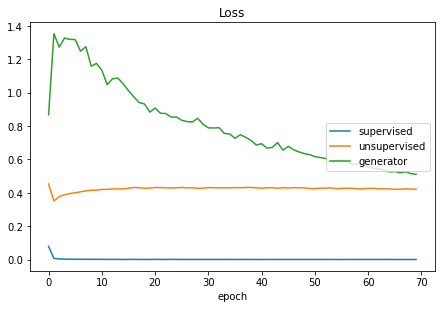

Loss
	supervised       	 (min:    0.000, max:    0.079, cur:    0.000)
	unsupervised     	 (min:    0.351, max:    0.453, cur:    0.422)
	generator        	 (min:    0.511, max:    1.353, cur:    0.511)

Done argsort
(96.17309999999998, 0.9155653700006265)
CPU times: user 53min, sys: 2min 10s, total: 55min 11s
Wall time: 1h 5min 43s


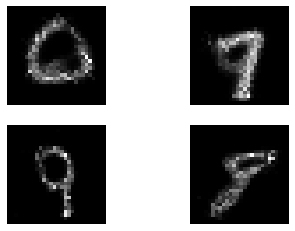

In [12]:
%%time
args.load_saved=True
args.epochs=70
args.labeled=100
args.features=16
args.mode = 'train'
gan = ImprovedGAN(Generator(z_dim=100), Discriminator(output_dim=args.features), MNISTTriplet(MNISTLabel(args.labeled/10)), MNISTUnlabel(), MNISTTest())

gan.train()
# gan.trainknn()
print(gan.evalknn(results))
show_gen_images(gan)

### Triplet M=16 N=200

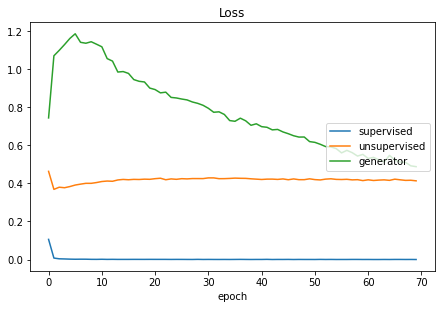

Loss
	supervised       	 (min:    0.000, max:    0.106, cur:    0.000)
	unsupervised     	 (min:    0.368, max:    0.463, cur:    0.413)
	generator        	 (min:    0.487, max:    1.185, cur:    0.487)

Done argsort
(96.44481666666665, 0.931573062438397)


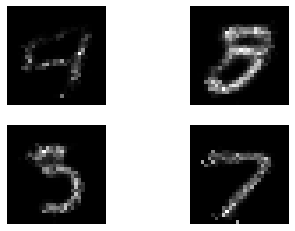

In [13]:
args.load_saved=True
args.epochs=70
args.labeled=200
args.features=16

gan = ImprovedGAN(Generator(z_dim=100), Discriminator(output_dim=args.features), MNISTTriplet(MNISTLabel(args.labeled/10)), MNISTUnlabel(), MNISTTest())
gan.train()
# gan.trainknn()
print(gan.evalknn(results))
show_gen_images(gan)

### Triplet M=32 N=100

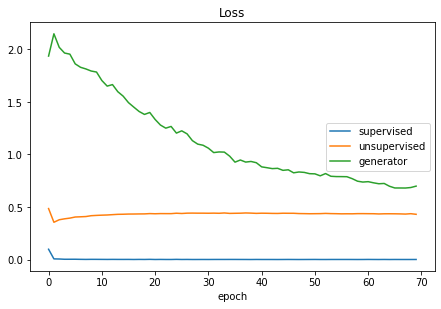

Loss
	supervised       	 (min:    0.000, max:    0.098, cur:    0.000)
	unsupervised     	 (min:    0.355, max:    0.485, cur:    0.430)
	generator        	 (min:    0.680, max:    2.149, cur:    0.699)

Done argsort
(95.97931666666668, 0.9031129058147167)


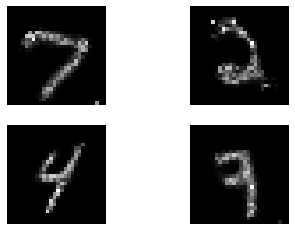

In [14]:
args.load_saved=True
args.epochs=70
args.labeled=100
args.features=32

gan = ImprovedGAN(Generator(z_dim=100), Discriminator(output_dim=args.features), MNISTTriplet(MNISTLabel(args.labeled/10)), MNISTUnlabel(), MNISTTest())
gan.train()
# gan.trainknn()
print(gan.evalknn(results))
show_gen_images(gan)

## Results

In [15]:
# batchwise iterate through data
# fit the batch for the classifier
# get accuracy and mAP

pprint(results)

{'train_16_100': [96.17309999999998, 0.9155653700006265],
 'train_16_200': [96.44481666666665, 0.931573062438397],
 'train_32_100': [95.97931666666668, 0.9031129058147167]}


# Clear GPU

In [16]:
#collapse-hide
# import gc
# def dump_tensors(gpu_only=True):
#         torch.cuda.empty_cache()
#         total_size = 0
#         for obj in gc.get_objects():
#             # print(obj)
#             try:
#                 if torch.is_tensor(obj):
#                     if obj.is_cuda:
#                         del obj
#                         gc.collect()
#                 elif hasattr(obj, "data") and torch.is_tensor(obj.data):
#                     if not gpu_only or obj.is_cuda:
#                         del obj
#                         gc.collect()
#             except Exception as e:
#                 pass
# dump_tensors()